In [1]:
import os
import sys

# os.path.join(os.path.dirname(__file__)
sys.path.append("../")  # location of config file
sys.path.append("../../") # working directory inside exploration
sys.path.append("../../../") 



import config

os.chdir("../../")

import glob
import numpy as np
from smartprint import smartprint as sprint
from preprocessing.ProcessRaw import ProcessRaw
from smartprint import smartprint as sprint
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [86]:
# ! rm -rf dist_plots
# ! mkdir dist_plots

london_45_days processed:  91%|█████████▏| 215/235 [00:00<00:00, 19355.56it/s]


start_date, end_date : 2020-02-01 2020-01-31
"Reached end of dates, skipping....Total #dates processed=", len(dates) : Reached end of dates, skipping....Total #dates processed= 215


/home/niskumar/NeurIPS2022-traffic4cast/train_data_all_cities/london-1-1-45-:   0%|          | 0/215 [00:00<?, ?it/s]
Repeating N times: 100%|██████████| 30/30 [01:56<00:00,  3.87s/it]


AttributeError: 'ProcessRaw' object has no attribute 'clean_intermediate_files'

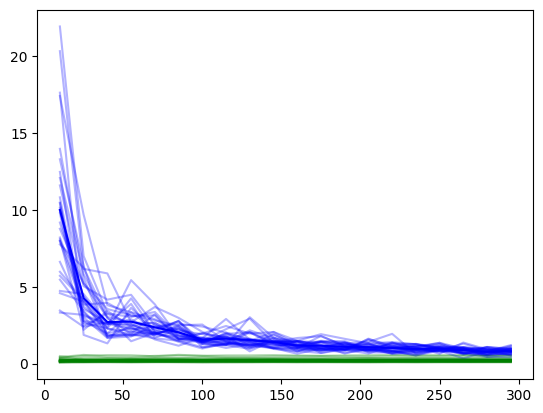

In [93]:

# ! pip install peakdetect==1.2

import matplotlib.patches as patches

def compute_temp_dist(file_list, query_point):
    random.shuffle(file_list)
        
    distances = []
    
    data_cache = {}
    sequential_delete = []
    # sprint (int(np.random.rand() * N), len(file_list))

    
    for i in (range(1, len(file_list))):
        neighbour_x_array = np.load(file_list[i])
        
        if "_x.npy" not in file_list[i]:
            raise Exception ("Wrong file supplied; we should not have _y files\n since we are looking for n-hood of x")
                    
        distances.append(np.max(np.abs(query_point - neighbour_x_array))) 
    return distances
        


from scipy.stats import entropy
smooth_window = np.nan # no longer being used

for cityname in ["london"]: # , "Madrid", "Melbourne"]:
    for scale in [45] :# , 105, 205]:
        for i_o_length in [1]:
            for pred_horiz in [1]: # [1]
                plt.clf()
                
                obj = ProcessRaw(cityname=cityname, i_o_length=i_o_length, prediction_horizon=pred_horiz, grid_size=scale)
                prefix = ProcessRaw.file_prefix(cityname, i_o_length, pred_horiz, scale)

                file_list = glob.glob("../train_data_all_cities/" + prefix + "/*_x.npy")

                        
                symmetric_KL_div_list_stacked = []
                cross_corr_list_stacked = []
                for repeat in tqdm(range(30), desc="Repeating N times"):
                    symmetric_KL_div_list = []
                    cross_corr_list = []
                    
                    N_range = np.arange(10, 300, 15)
                    BINS = np.arange(0, 7000, 100)
                    
                    # choose a query point
                    n = int(np.random.rand() * len(file_list))
                    query_point = np.load(file_list[n])                    
                    
                    distances = compute_temp_dist(file_list[:-1], query_point)
                    hist_all = np.histogram(distances, bins=BINS)[0]
                    pdf_dist_all = hist_all / hist_all.sum() + 1e-16                        
                    
                    for N in N_range:

                        random.shuffle(file_list)
                        
                        distances = compute_temp_dist(file_list[:N], query_point)
                        hist_sample = np.histogram(distances, bins=BINS)[0]
                        pdf_dist_sample = hist_sample / hist_sample.sum() + 1e-16

                        symmetric_KL_div = entropy(pdf_dist_sample, pdf_dist_all) + \
                                           entropy(pdf_dist_all, pdf_dist_sample) 
                        
                        correlation_valid_pad = (np.correlate(pdf_dist_all, pdf_dist_sample)).flatten().tolist()
                        assert len(correlation_valid_pad) == 1

                        symmetric_KL_div_list.append(symmetric_KL_div)
                        cross_corr_list.append(correlation_valid_pad[0])
                    
                        # live plot to see progress as more points are added
                        # plt.plot(symmetric_KL_div_list, alpha=0.5)
                        # plt.savefig("dist_plots/" + "Single point KL-div (whole data, sample) \n"+prefix + ".png")
                        
                    symmetric_KL_div_list_stacked.append(symmetric_KL_div_list)
                    cross_corr_list_stacked.append(cross_corr_list)
                    
                    plt.plot(N_range, symmetric_KL_div_list, alpha=0.3, color="blue")
                    plt.plot(N_range, cross_corr_list, alpha=0.3, color="green")
                    
                plt.plot(N_range, np.mean(np.array(symmetric_KL_div_list_stacked), axis=0), \
                     alpha=1, color="blue", label="Mean-KL-div")
                    
                plt.plot(N_range, np.mean(np.array(cross_corr_list_stacked), axis=0), \
                     alpha=1, color="green", label="Mean-Corr-plot")                
                
                obj.clean_intermediate_files()
                
            plt.xlabel("sample size(N)")
            plt.xticks(N_range, rotation=90, fontsize=8)
            plt.legend()
            plt.title("Single point KL-div whole data vs sample pdf \n"+prefix)
            plt.savefig("dist_plots/" + "Single point KL-div (whole data, sample) \n"+prefix + ".png")
            plt.clf()

                        

[18.58199299673754,
 6.752468106872872,
 3.128082597407397,
 3.2995579758874056,
 2.163578334845474,
 1.986212313174741,
 2.4160177529061717,
 1.406863303480888,
 1.8125661207675243,
 1.9732945930611296,
 1.2821583052268961,
 1.6560462481749394,
 1.6750789499075855,
 0.9244844800616904,
 0.5601309812357426,
 1.1677984652585578,
 0.8197334243116934,
 0.7350556157300315,
 0.82748947007523,
 0.8337758122799113]